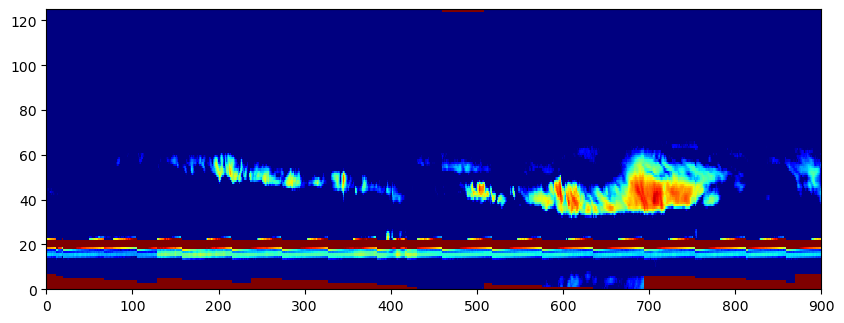

In [1]:
import glob
from netCDF4 import Dataset
from csIO import *
import numpy as np
import matplotlib.pyplot as plt

def process(dbz,cpr_cmask,temp,iwc,re,height,iwp):
    a=np.nonzero(np.array(iwp)>0)
    b=np.nonzero(temp[a].max(axis=1)>280)
    a=a[0][b]
    temp0L=[]
    isfcPrecip=0
    iwp1L=[]
    iwp2L=[]
    iwcL=[]
    reL=[]
    zwL=[]
    iL=[]
    dbzL=[]
    ikL=[]
    hL=[]
    for i in a[0:]:
        b1=np.nonzero(temp[i]<273.15)
        ik=b1[0][-1]
        nprecip1=np.nonzero(cpr_cmask[i,ik:100]>30)
        #print(height[i,ik+3-40:ik+3])
        #stop:
        #print(ik,len(nprecip1[0]))
        temp0L.append(ik)
        if(len(nprecip1[0])>3):
            isfcPrecip+=1
            #print(cpr_cmask[i,ik:100])
            #print(nprecip1[0])
            dbz[i,:]=-99
        else:
            if ik+3-40>0:
                iwp1L.append(iwp[i])
                iwp2L.append(iwc[i,ik+3-40:ik+3].data.sum()*0.24)
                iwcL.append(iwc[i,:])
                reL.append(re[i,:])
                zwL.append(dbz[i,ik+3-40:ik+3])
                iL.append(i)
                dbzL.append(dbz[i,:])
                ikL.append(ik)
                hL.append(height[i,ik+3])
    return iwp1L,iwp2L,zwL,iwcL,reL,iL,dbzL,ikL,hL

fs=sorted(glob.glob("data/2019*hdf"))
fs_2B=sorted(glob.glob("CloudSat_2B/2019*hdf"))
import xarray as xr
for i,f in enumerate(fs[:-14]):
    iwc,dbz_sim,temp2C,re,height,lonC,latC,iwp=read2C_ICE(f)
    fh=Dataset(fs_2B[i+14])
    dbz=fh['Radar_Reflectivity'][:]/100.
    cpr_cmask=fh['CPR_Cloud_mask'][:]
    iwp1L,iwp2L,zwL,iwcL,reL,iL,dbzL,ikL,hL_2C=process(dbz,cpr_cmask,temp2C,iwc,re,height,iwp)
    break
    stop
    ds=xr.Dataset({'iwp':(['nt'],iwp1L),'zw':(['nt','nz'],zwL),\
                   'iwc':(['nt','nz'],iwcL),'re':(['nt','nz'],reL)})
    orbit=f.split('_')[1]
    fname_out='anvData/cs_profs_%s.nc'%orbit
    ds.to_netcdf(fname_out,encoding={'iwp':{'zlib':True},'zw':{'zlib':True},\
                                     'iwc':{'zlib':True},'re':{'zlib':True}})
    print(orbit,fs_2B[i+14].split('_')[2])
    #break



    
    
#plt.hist(iwp[a])
#n4=int(len(a)/4)
for i in range(1):
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    dbzm=np.ma.array(dbz,mask=dbz<-25)
    a=range(900)
    a=np.array(iL)
    dbzL=np.array(dbzL)
    plt.pcolormesh(dbzL[:900,::-1].T,cmap='jet',vmin=-20,vmax=15)
    #plt.plot(temp0L)
    #plt.xlim(i*n4,(i+1)*n4)
    #plt.ylim(105,45)
    #plt.colorbar()
    #plt.subplot(212)
    #plt.pcolormesh(cpr_cmask[a,:].T,cmap='jet')
    #plt.xlim(i*n4,(i+1)*n4)
    #plt.plot(temp0L)
    #plt.ylim(105,45)
    #plt.colorbar()


In [2]:
print(np.array(lonC).shape)
lonC=np.array(lonC)
latC=np.array(latC)
dbzL=np.array(dbzL)
print(dbzL.shape)
#print(hL[:30])

(36950, 1)
(4394, 125)


In [3]:
import pickle
from kazrRet import *
import netCDF4 as nc

iwcCoeff_SSRG=np.polyfit(zST[2,:],np.log10(iwcST[2,:]),1)
dnCoeff=np.array([0.01381017, 0.54397871])
dnCoeff=np.array([0.01975583, 0.22])
dn1D=np.polyval(dnCoeff,range(60))
with nc.Dataset('../kext_atm74.nc','r') as f:
    kext_atm=f.variables['kext_atm'][:]
    kext_atm=np.array(kext_atm)

with nc.Dataset('../profiles74.nc','r') as f:
    qv=f.variables['qv'][:]
    press=f.variables['press'][:]
    temp=f.variables['temp'][:]
    tempm=f.variables['tempm'][:]
    pressf=f.variables['pressf'][:]
    rho=f.variables['rho'][:]

kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]

npart=4
undef=0.0
nrefl=2
ice_type=1
import lidarSim as lidar
def get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice):
    h1=dr/2+np.arange(nz)*dr
    h1f=np.arange(nz)*dr
    q_lsice1=iwc1/rho1*1e-3
    q_lsice=q_lsice1[np.newaxis,:]
    pres1=pres1[np.newaxis,:]
    presf1=presf1[np.newaxis,:]
    temp1=temp1[np.newaxis,:]
    q_lsliq=np.zeros((1,nz),float)
    ls_radice=dm_ice/1*1e-3
    ls_radice=ls_radice[np.newaxis,:]
    ls_radliq=np.zeros((1,nz),float)
    q_cvice=np.zeros((1,nz),float)
    cv_radice=np.zeros((1,nz),float)
    q_cvliq=np.zeros((1,nz),float)
    cv_radliq=np.zeros((1,nz),float)
    temp=temp1
    pres=pres1
    presf=presf1
    pmol,pnorm,pnorm_perp_tot,\
        tautot,betatot_liq,\
        betatot_ice,\
        betatot,refl, \
        zheight,\
        beta_mol, tau_mol,\
        alpha= lidar.lidar_simulator(npart,nrefl,undef,\
                                     pres1,presf1,\
                                     temp1,
                                     q_lsliq,q_lsice,\
                                     q_cvliq,\
                                     q_cvice,\
                                     ls_radliq,\
                                     ls_radice,\
                                     cv_radliq,cv_radice,\
                                     ice_type)
    return pmol,pnorm

In [4]:
import lidarSim 
import importlib
importlib.reload(lidarSim)
lidar=lidarSim
print(dir(lidarSim))
lidSim=lidar
zkuCoeff=np.polyfit(zST[2,:30],(zST[0,:30]),1)
dmCoeff=np.polyfit(zST[2,:30],np.log(dmST[2,:30]),1)
iwcLowCoeff=np.polyfit(zST[2,:30],np.log(iwcST[2,:30]),1)
kextCoeffL=[np.polyfit(zST[k,:30],np.log10(kextST[k,:30]),1) for k in range(4)]

['__doc__', '__f2py_numpy_version__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_lidarSim_error', 'band', 'banddec', 'bandsol', 'bisection2', 'lidar_simulator', 'parasol', 'radtran', 'swap']


In [5]:
zKuL=[]
pnormL=[]
pmolL=[]
tbL=[]
dm_SSRGL=[]
iwc_SSRGL=[]
iwc_SSRG=np.zeros((900,60),float)
dm_SSRG=np.zeros((900,60),float)
pnorm_SSRG=np.zeros((900,60),float)
pnormL=[]
pmolL=[]
umu=np.cos(0)
fisot=2.7
nz=74
height=np.arange(nz+1)*0.240
print(height.shape)
import tqdm
iwcL=np.array(iwcL)
reL=np.array(reL)
for i1 in tqdm.tqdm(range(900)):
    zw1=dbzL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1]
    iwc2C_ICE=iwcL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1]
    dm2C_ICE=reL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1]*2.75e-3
    a1=np.nonzero(zw1>-25)
    iwp1=0.0
    iwp2=0.0
    kextI=np.zeros((60,4),float)
    salbI=np.zeros((60,4),float)
    asymI=np.zeros((60,4),float)
    zKu=np.zeros((60),float)-99
    ic=np.random.randint(0,30)
    kext1D=kext_atm[ic,:,:].copy()
    salb1D=np.zeros((74,4),float)
    asym1D=np.zeros((74,4),float)
    for k in a1[0]:
        zw11=zw1[k] 
        k0=k
        ifind = lidSim.bisection2(zST[2,:],zw11-10.*dn1D[k])
        ifind-=1
        #print(zST[2,ifind-1],zw11,zST[2,ifind])
        dz=zST[2,ifind+1]-zST[2,ifind]
        w1=(zw11-10.*dn1D[k]-zST[2,ifind])/dz
        z1ku=zST[0,ifind]*w1+zST[0,ifind+1]*(1-w1)+10*dn1D[k]
        iwc1=(iwcST[2,ifind]*w1+iwcST[2,ifind+1]*(1-w1))*10**dn1D[k]
        dm1=(dmST[2,ifind]*w1+dmST[2,ifind+1]*(1-w1))
        if zw11-10*dn1D[k]<zST[2,0]:
            z1ku=zkuCoeff[0]*(zw11-10*dn1D[k])+zkuCoeff[1]+10*dn1D[k]
            iwc1=np.exp(iwcLowCoeff[0]*(zw11-10*dn1D[k])+iwcLowCoeff[1])*10**dn1D[k]
            dm1=np.exp(dmCoeff[0]*(zw11-10*dn1D[k])+dmCoeff[1])
        i0=int(z1ku+20)
        if zw11-10*dn1D[k]>=zST[2,0]:
            for ifreq in range(4):
                kextI[k,ifreq]=kextST[ifreq+2,ifind]*10**(dn1D[k])
                salbI[k,ifreq]=kscaST[ifreq+2,ifind]
                asymI[k,ifreq]=gST[ifreq+2,ifind]
        else:
            for ifreq in range(4):
                kextI[k,ifreq]=10**(kextCoeffL[ifreq][0]*(zw11-10*dn1D[k])+kextCoeffL[ifreq][1]+dn1D[k])
                salbI[k,ifreq]=kextI[k,ifreq]*kscaST[ifreq+2,0]/kextST[ifreq+2,0]  
                asymI[k,ifreq]=gST[ifreq+2,0]
        zKu[k]=z1ku
        i0=int(zw11+20)
        iwc_SSRG[i1,k]=iwc1
        dm_SSRG[i1,k]=dm1
    a2=np.nonzero(iwc2C_ICE>0)
    b=np.nonzero(zw1[a2]<=-25)
    for k in a2[0][b]:
        iwc_SSRG[i1,k]=iwc2C_ICE[k]
        dm_SSRG[i1,k]=1.1*dm2C_ICE[k]
    
    kext1D[14:74,:]+=kextI[:,:]
    salb1D[14:74,:]=salbI[:,:]
    asym1D[14:74,:]=asymI[:,:]
    salb1D/=kext1D
    emis=0.8+np.random.random()*0.2
    ebar=emis
    tb1=[]
    #iwcL.append(iwc[i1,:])
    #print(temp[ic].shape)
    #print(kext1D.shape)
    for ik in range(4):
        tbout = lidSim.radtran(umu,temp[ic][0],temp[ic],height,kext1D[:,ik],salb1D[:,ik],asym1D[:,ik],fisot,emis,ebar)
        tb1.append(tbout)
        if tbout!=tbout:
            stop
    tbL.append(tb1)
    nz=60
    dr=0.240
    temp1=temp[ic,14:74]
    pres1=press[ic,14:74]
    presf1=pressf[ic,14:75]
    qv1=qv[ic,14:74]
    iwc1=iwc_SSRG[i1,:]
    rho1=pres1/(287.05*temp1)
    dm_ice=dm_SSRG[i1,:]
    pmol,pnorm=get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice)
    pnorm_SSRG[i1,:]=pnorm
    pnormL.append(pnorm[0,:])
    pmolL.append(pmol[0,:])
    zKuL.append(zKu)
    
#plt.pcolormesh(p)

(75,)


100%|██████████| 900/900 [00:00<00:00, 1353.54it/s]


In [6]:
pnormL=np.array(pnormL)
ss=np.shape(pnormL)
#print(np.array(ikL)[0:900])


In [146]:
#print(temp1)
#print(presf1)
#print(iwc1)
#print(dm_ice)
#print(rho1)

12943 15214
(4394, 125)
<class 'numpy.ndarray'>


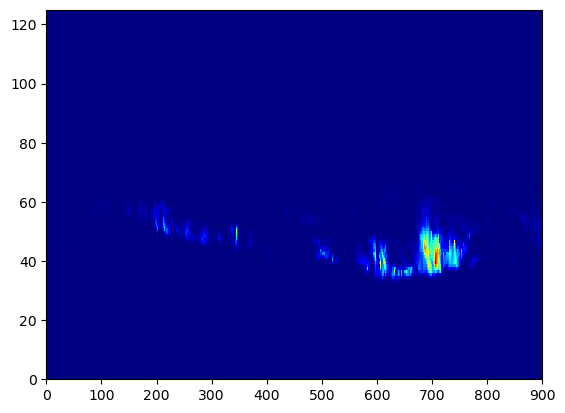

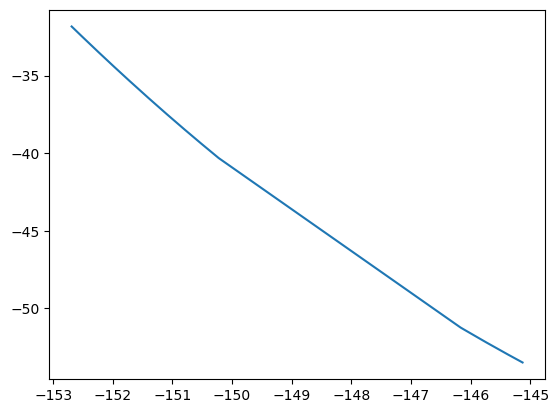

In [7]:
print(iL[0],iL[900])
iwcL=np.array(iwcL)
print(iwcL.shape)
plt.pcolormesh(np.array(iwcL)[0:900,::-1].T,cmap='jet')
#print(f)
plt.figure()
print(type(lonC))
lonC=np.array(lonC)[:]
latC=np.array(latC)[:]
plt.plot(lonC[np.array(iL[:900])],latC[np.array(iL[:900])])

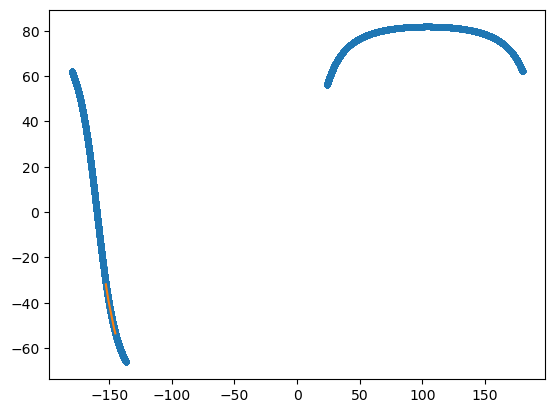

In [22]:
lidFile='CAL_LID_L1-Standard-V4-51.2019-05-12T03-08-31ZN.hdf'
lidFile='CAL_LID_L1-Standard-V4-51.2019-05-31T23-24-14ZN.hdf'
#lidFile='CAL_LID_L1-Standard-V4-51.2019-05-31T22-32-04ZD.hdf'
lidFile='CAL_LID_L1-Standard-V4-51.2019-06-01T00-10-34ZD.hdf'
fh=Dataset(lidFile)
#lat=fh['Latitude']
#lon=fh['Longitude']
#print(lat)
#lat=lat[0]
# open the file using xarray

from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V    
import numpy as np

# get the data
hdf=SD(lidFile)
d=hdf.select('Latitude')
latL=d[:][:,0]
d=hdf.select('Longitude')
lonL=d[:][:,0]
d=hdf.select('Total_Attenuated_Backscatter_532')
bscat=d[:]
d=hdf.select('Pressure')
pressLid=d[:]
tempLid=hdf.select('Temperature')[:]
#qvLid=hdf.select('Specific_Humidity')[:]
#vs = hdf.vstart()
    
#read 'latitude' from hdf
#lat = vs.attach('Latitude')
#lat=hdf.select('Latitude')
#print(dir(hdf))
bscatL=[]
#stop
plt.plot(lonL,latL,'.')
iL=np.array(iL)
#plt.plot(lon[np.array(iL[:900])],lat[np.array(iL[:900])])
# find the index of the closest point in (lonL,latL) to (lon,lat)
# find the index of the closest point in (lonL,latL) to (lon,lat)
icL=[]
#288 is at 8.8 km
ip=0
h1=20.2-(np.arange(89,289)-90)*0.06+0.01
h2=8.3-(np.arange(289,578)-289)*0.03
#print(h1)
#print(h2[0:10])
#print(h2[-10:])
hL=np.concatenate((h1,h2))
for lon1,lat1 in zip(lonC[iL[0:900]],latC[iL[0:900]]):
    rms=(lonL-lon1)**2+(latL-lat1)**2
    ind=np.argmin(rms)
    icL.append(ind)
    #print(lonL[ind],latL[ind],lon1,lat1)
    count=np.zeros(60)
    bscatAv=np.zeros(60)
    for k in range(89,578):
        ibin=int((hL[k-89]-hL_2C[ip]/1e3)/0.240)
        if ibin>=0 and ibin<60:
            bscatAv[ibin]+=bscat[ind,k]
            count[ibin]+=1
    a=np.where(count>0)
    bscatAv[a]/=count[a]
    bscatL.append(bscatAv)
    ip+=1
    #bscatL.append(hL[ip]/1e3+.240*np.arange(40),bscat[ind,89:578][::-1]))
plt.plot(lonC[iL[0:900]],latC[iL[0:900]])

In [14]:
a=np.nonzero(tempLid[ind,:]<0)
print(tempLid[ind,:])
print(a)

[-3.6441654e+01 -3.8325050e+01 -4.1629814e+01 -4.4082466e+01
 -4.6536362e+01 -4.8042854e+01 -5.0003872e+01 -5.3001347e+01
 -5.6769360e+01 -6.0993240e+01 -6.3957886e+01 -6.5031029e+01
 -6.6034142e+01 -6.6959267e+01 -6.5026642e+01 -6.1461300e+01
 -5.7558205e+01 -5.5284901e+01 -5.5575493e+01 -5.4247192e+01
 -4.8681873e+01 -4.0049850e+01 -3.1271160e+01 -2.2933582e+01
 -1.5425331e+01 -1.1017378e+01 -7.9023414e+00 -2.2333461e-01
  5.2437811e+00  1.0046490e+01  1.9146780e+01 -9.9990000e+03
 -9.9990000e+03]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32]),)


0.20989960530641838


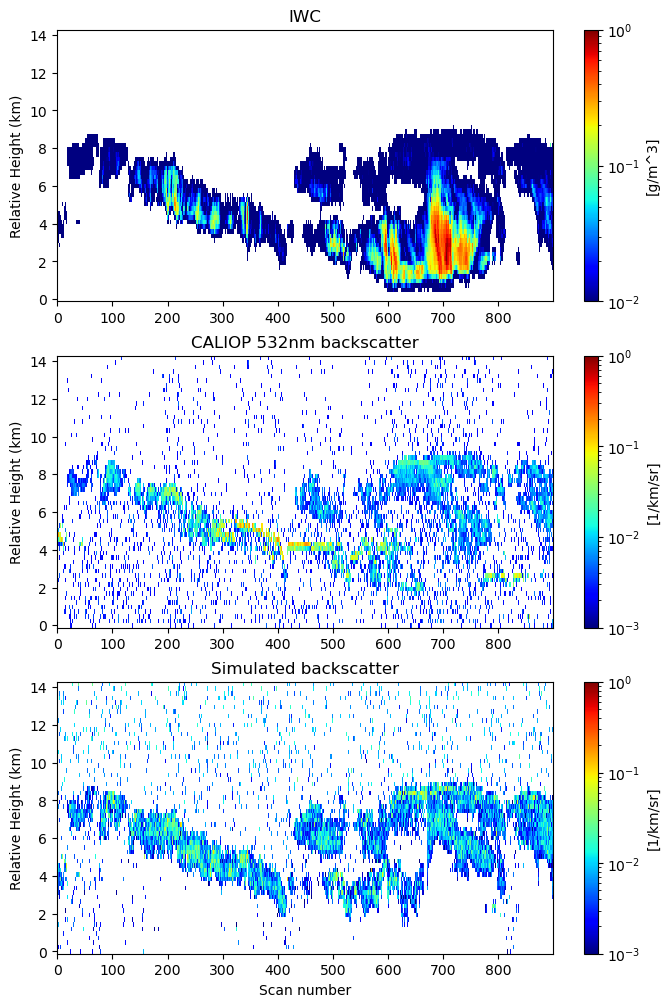

In [38]:
bscatL=np.array(bscatL)
print(bscatL.max())
pnormL=np.array(pnormL)
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8,12))
plt.subplot(312)
bscatLm=np.ma.array(bscatL,mask=bscatL<2e-3)
plt.pcolormesh(np.arange(900),np.arange(60)*0.24,bscatLm[:900,:].T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1e0))
plt.ylabel('Relative Height (km)')
#plt.ylim(588,89)
#plt.plot(range(900),[288]*900)
#print(bscatL.max())
#plt.contour(np.arange(900),np.arange(60)*0.24,1e3*pnormLm.T*np.exp(0.5*np.random.randn(ss[1],ss[0])),cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1e-0))

plt.title('CALIOP 532nm backscatter')
cbar=plt.colorbar(orientation='vertical')
cbar.ax.set_ylabel('[1/km/sr]')
plt.subplot(313)

pnormLm=np.ma.array(pnormL,mask=pnormL<2e-6)
plt.pcolormesh(np.arange(900),np.arange(60)*0.24,1e3*pnormLm.T*np.exp(0.5*np.random.randn(ss[1],ss[0])),cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1e-0))
plt.title('Simulated backscatter')
plt.xlabel('Scan number')
plt.ylabel('Relative Height (km)')
cbar=plt.colorbar(orientation='vertical')
# add labels to the colorbar
cbar.ax.set_ylabel('[1/km/sr]')
plt.subplot(311)
#plt.pcolormesh(np.array(iwcL)[0:900,::-1].T,cmap='jet')
iwc2C_ICE=[iwcL[i1,ikL[i1]-60+3:ikL[i1]+3][::-1] for i1 in range(900)]
iwc2C_ICE=np.array(iwc2C_ICE)
iwc_SSRG=np.zeros((900,60),float)
iwcLm=np.ma.array(iwc2C_ICE,mask=iwc2C_ICE<1e-6)
plt.pcolormesh(np.arange(900),np.arange(60)*0.24,iwcLm[:900,:].T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-2,vmax=1e-0))
plt.ylabel('Relative Height (km)')
cbar=plt.colorbar(orientation='vertical')
cbar.ax.set_ylabel('[g/m^3]')
plt.title('IWC')
plt.savefig('simCALIOPbscatter.png')


In [35]:
print(bscat.shape)
# Malcom X was an activist
# SMCE environment
#plt.plot(bscatL.mean(axis=0))
#plt.plot(1e3*pnormL.mean(axis=0))
bscatL[bscatL<1e-3]=0
pnormL[pnormL<1e-6]=0
print(np.corrcoef((bscatL).mean(axis=1),(1e3*pnormL).mean(axis=1)))
a=np.nonzero(bscatL>=0*1e-3)
b=np.nonzero(pnormL[a]>=0*1e-6)
a=np.nonzero(bscatL[a]>2e-3)
b=np.nonzero(pnormL>2e-6)
print(len(a[0])/len(b[0]))
#print(np.corrcoef(bscatL[a][b],pnormL[a][b]))
#plt.loglog(bscatL[a][b],pnormL[a][b],'*')


(63120, 583)
[[1.         0.28285281]
 [0.28285281 1.        ]]
0.9353015605229861
